# SSP emissions runs using CMIP6 calibrations: monthly timestep

See `cmip6_ssp_emissions_run`.

The stochastic response appears to be too small using the calibrated 4xCO2 values for sigma_eta and sigma_xi. No rescaling of these values is done in the energy balance code, though in the constrution of the energy balance model diving the sigmas by the square root of the timestep seems to approximately reproduce the right level of variability. I do this here.

In [1]:
import numpy as np
import matplotlib.pyplot as pl
import pandas as pd

from fair import FAIR
from fair.io import read_properties
from fair.interface import fill, initialise
from fair.earth_params import seconds_per_year

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
f = FAIR(ch4_method='thornhill2021')

## 2. Define time horizon

create world running from 1750 to 2100, at monthly intervals

In [5]:
f.define_time(1750, 2100, 1/12)

In [6]:
f.timebounds[:5], f.timebounds[-5:]

(array([1750.        , 1750.08333333, 1750.16666667, 1750.25      ,
        1750.33333333]),
 array([2099.66666667, 2099.75      , 2099.83333333, 2099.91666667,
        2100.        ]))

In [7]:
f.timepoints[:5], f.timepoints[-5:]

(array([1750.04166667, 1750.125     , 1750.20833333, 1750.29166667,
        1750.375     ]),
 array([2099.625     , 2099.70833333, 2099.79166667, 2099.875     ,
        2099.95833333]))

In [8]:
scenarios = ['ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp434', 'ssp460', 'ssp534-over', 'ssp585']
f.define_scenarios(scenarios)

In [9]:
df = pd.read_csv("../data/calibration/4xCO2_cummins_ebm3.csv")
models = df['model'].unique()
configs = []

for imodel, model in enumerate(models):
    for run in df.loc[df['model']==model, 'run']:
        configs.append(f"{model}_{run}")
f.define_configs(configs)

In [10]:
species, properties = read_properties()

In [11]:
f.define_species(species, properties)

In [12]:
f.allocate()

In [13]:
f.emissions

<xarray.DataArray (timepoints: 4200, scenario: 8, config: 66, specie: 63)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]])
Coordinates:
  * timepoints  (timepoints) float64 1.75e+03 1.75e+03 ... 2.1e+03 2.1e+03
  * scenario    (scenario) <U11 'ssp119' 'ssp126' ... 'ssp534-over' 'ssp585'
  * config      (config) <U24 'CAMS-CSM1-0_r1i1p1f1' ... 'MIROC-ES2L_r1i1p1f2'
  * specie      (specie) <U43 'CO2 FFI' ... 'Equivalent effective stratospher...

In [14]:
f.fill_species_configs()
fill(f.species_configs['unperturbed_lifetime'], 10.8537568, specie='CH4')
fill(f.species_configs['baseline_emissions'], 19.01978312, specie='CH4')
fill(f.species_configs['baseline_emissions'], 0.08602230754, specie='N2O')

In [15]:
df_volcanic = pd.read_csv('../data/forcing/volcanic_ERF_monthly_-950001-201912.csv', index_col='year')

In [16]:
f.fill_from_rcmip()

# overwrite volcanic
volcanic_forcing = np.zeros(4201)
volcanic_forcing[:270*12] = df_volcanic[1750:].squeeze().values
fill(f.forcing, volcanic_forcing[:, None, None], specie="Volcanic")  # sometimes need to expand the array

initialise(f.concentration, f.species_configs['baseline_concentration'])
initialise(f.forcing, 0)
initialise(f.temperature, 0)
initialise(f.cumulative_emissions, 0)
initialise(f.airborne_emissions, 0)

In [17]:
df = pd.read_csv("../data/calibration/4xCO2_cummins_ebm3.csv")
models = df['model'].unique()

seed = 1355763

# remember we rescale sigma
for config in configs:
    model, run = config.split('_')
    condition = (df['model']==model) & (df['run']==run)
    fill(f.climate_configs['ocean_heat_capacity'], df.loc[condition, 'C1':'C3'].values.squeeze(), config=config)
    fill(f.climate_configs['ocean_heat_transfer'], df.loc[condition, 'kappa1':'kappa3'].values.squeeze(), config=config)
    fill(f.climate_configs['deep_ocean_efficacy'], df.loc[condition, 'epsilon'].values[0], config=config)
    fill(f.climate_configs['gamma_autocorrelation'], df.loc[condition, 'gamma'].values[0], config=config)
    fill(f.climate_configs['sigma_eta'], df.loc[condition, 'sigma_eta'].values[0]/np.sqrt(f.timestep), config=config)
    fill(f.climate_configs['sigma_xi'], df.loc[condition, 'sigma_xi'].values[0]/np.sqrt(f.timestep), config=config)
    fill(f.climate_configs['stochastic_run'], True, config=config)
    fill(f.climate_configs['use_seed'], True, config=config)
    fill(f.climate_configs['seed'], seed, config=config)
    
    seed = seed + 399

In [18]:
f.run()

Running 528 projections in parallel:   0%|          | 0/4200 [00:00<?, ?timesteps/s]

Text(0, 0.5, 'Temperature anomaly (K)')

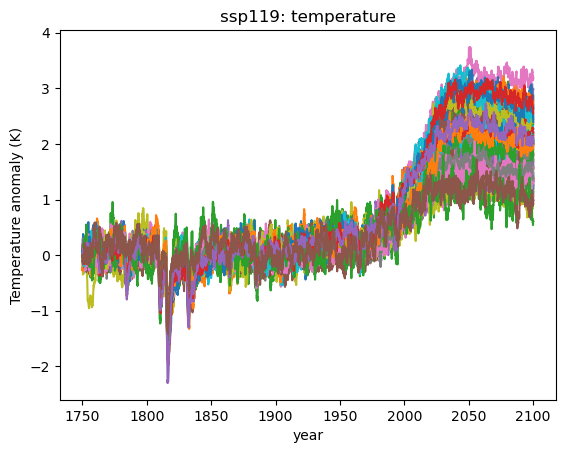

In [19]:
pl.plot(f.timebounds, f.temperature.loc[dict(scenario='ssp119', layer=0)], label=f.configs);
pl.title('ssp119: temperature')
pl.xlabel('year')
pl.ylabel('Temperature anomaly (K)')

Text(0, 0.5, 'Temperature anomaly (K)')

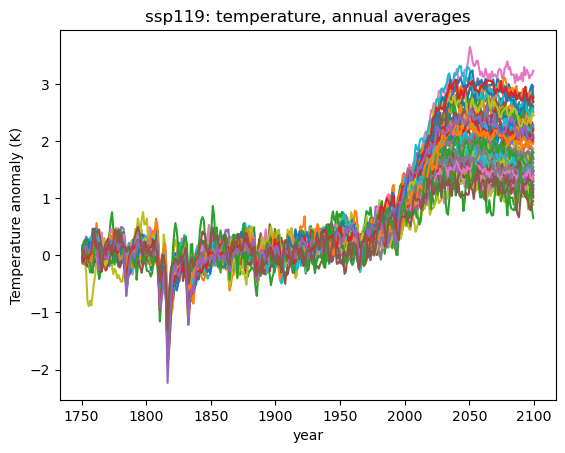

In [20]:
import numpy as np
t_mean = np.zeros((350, 66))
for i in range(350):
    t_mean[i, :] = f.temperature.loc[dict(scenario='ssp119', layer=0)][i*12:i*12+12, :].mean(axis=0)

pl.plot(np.arange(1750.5, 2100), t_mean, label=f.configs);
pl.title('ssp119: temperature, annual averages')
pl.xlabel('year')
pl.ylabel('Temperature anomaly (K)')

Text(0, 0.5, 'methane lifetime (yr)')

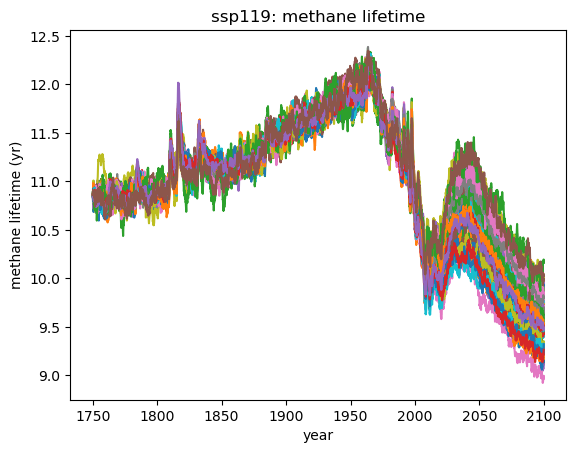

In [21]:
pl.plot(f.timebounds, f.species_configs['unperturbed_lifetime'].loc[dict(specie='CH4', gasbox=0)].data * f.alpha_lifetime.loc[dict(scenario='ssp119', specie='CH4')], label=f.configs);
pl.title('ssp119: methane lifetime')
pl.xlabel('year')
pl.ylabel('methane lifetime (yr)')

Text(0, 0.5, 'W/m2')

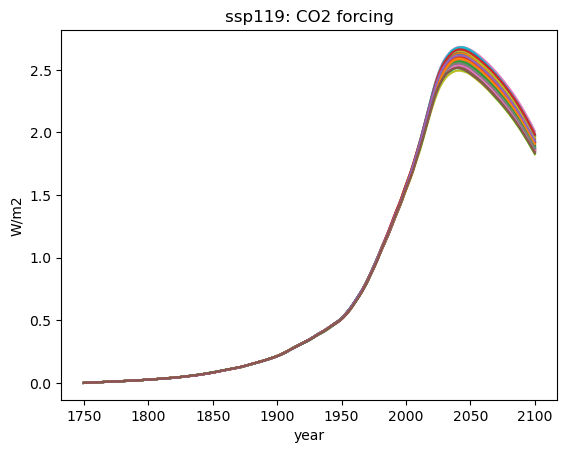

In [22]:
pl.plot(f.timebounds, f.forcing.loc[dict(scenario='ssp119', specie='CO2')], label=f.configs);
pl.title('ssp119: CO2 forcing')
pl.xlabel('year')
pl.ylabel('W/m2')

Text(0, 0.5, 'W/m2')

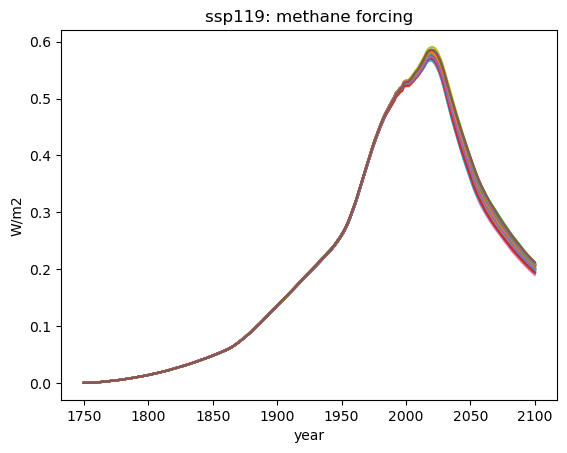

In [23]:
pl.plot(f.timebounds, f.forcing.loc[dict(scenario='ssp119', specie='CH4')], label=f.configs);
pl.title('ssp119: methane forcing')
pl.xlabel('year')
pl.ylabel('W/m2')

Text(0, 0.5, 'Temperature anomaly (K)')

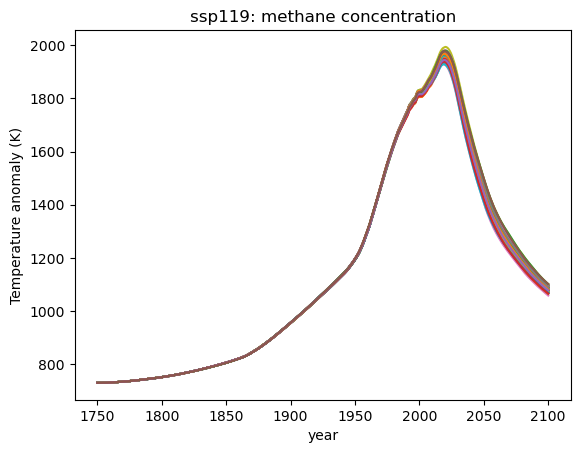

In [24]:
pl.plot(f.timebounds, f.concentration.loc[dict(scenario='ssp119', specie='CH4')], label=f.configs);
pl.title('ssp119: methane concentration')
pl.xlabel('year')
pl.ylabel('Temperature anomaly (K)')

Text(0, 0.5, 'ppt')

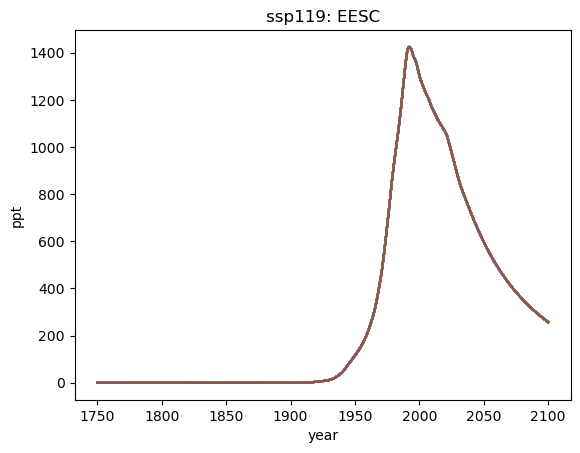

In [25]:
pl.plot(f.timebounds, f.concentration.loc[dict(scenario='ssp119', specie='Equivalent effective stratospheric chlorine')], label=f.configs);
pl.title('ssp119: EESC')
pl.xlabel('year')
pl.ylabel('ppt')

Text(0, 0.5, 'ppb')

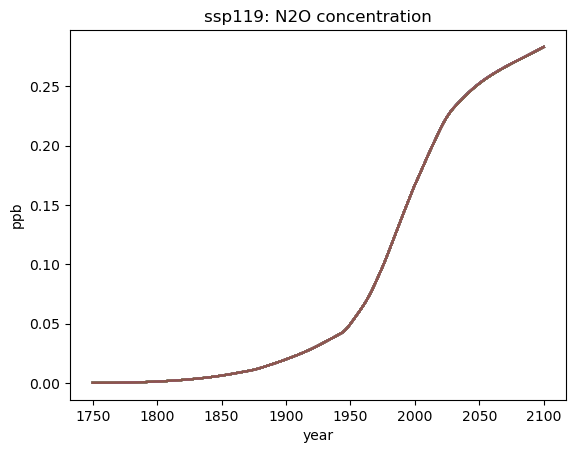

In [26]:
pl.plot(f.timebounds, f.forcing.loc[dict(scenario='ssp119', specie='N2O')], label=f.configs);
pl.title('ssp119: N2O concentration')
pl.xlabel('year')
pl.ylabel('ppb')

Text(0, 0.5, 'W/m2')

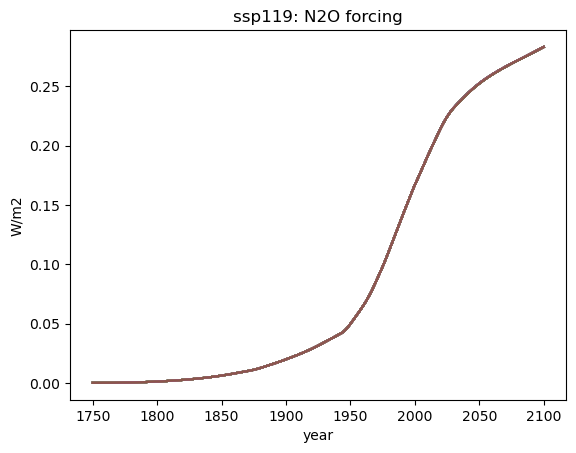

In [27]:
pl.plot(f.timebounds, f.forcing.loc[dict(scenario='ssp119', specie='N2O')], label=f.configs);
pl.title('ssp119: N2O forcing')
pl.xlabel('year')
pl.ylabel('W/m2')

Text(0, 0.5, 'ppt')

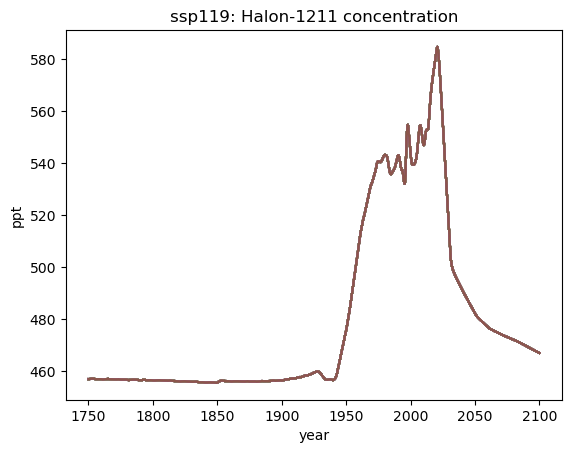

In [28]:
pl.plot(f.timebounds, f.concentration.loc[dict(scenario='ssp119', specie='CH3Cl')], label=f.configs);
pl.title('ssp119: Halon-1211 concentration')
pl.xlabel('year')
pl.ylabel('ppt')

Text(0, 0.5, 'W/m2')

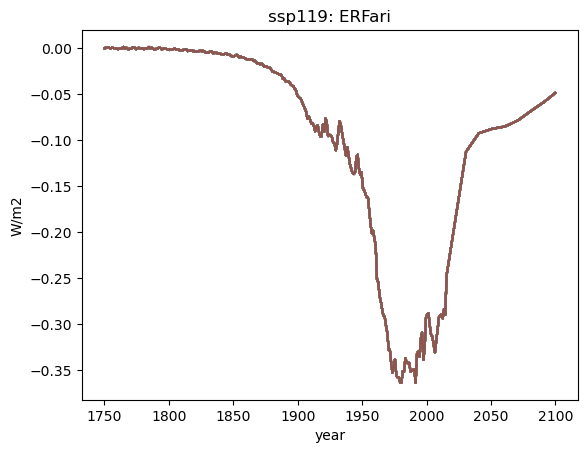

In [29]:
pl.plot(f.timebounds, f.forcing.loc[dict(scenario='ssp119', specie='Aerosol-radiation interactions')], label=f.configs);
pl.title('ssp119: ERFari')
pl.xlabel('year')
pl.ylabel('W/m2')

Text(0, 0.5, 'W/m2')

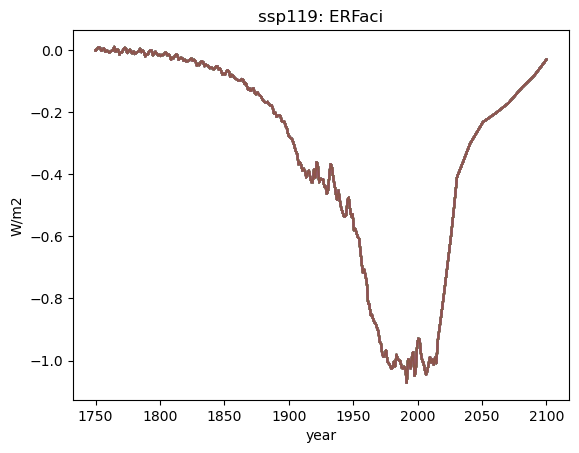

In [30]:
pl.plot(f.timebounds, f.forcing.loc[dict(scenario='ssp119', specie='Aerosol-cloud interactions')], label=f.configs);
pl.title('ssp119: ERFaci')
pl.xlabel('year')
pl.ylabel('W/m2')

Text(0, 0.5, 'W/m2')

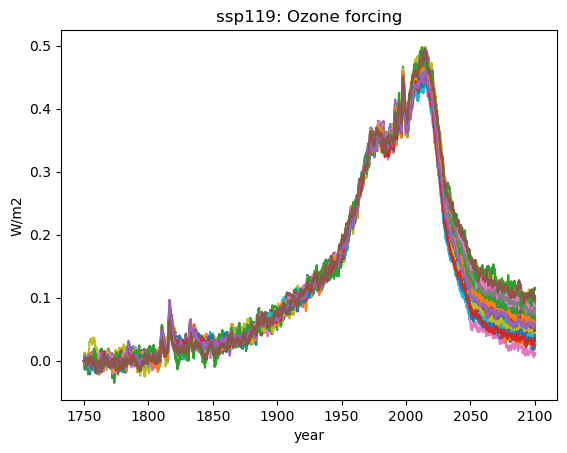

In [31]:
pl.plot(f.timebounds, f.forcing.loc[dict(scenario='ssp119', specie='Ozone')], label=f.configs);
pl.title('ssp119: Ozone forcing')
pl.xlabel('year')
pl.ylabel('W/m2')

Text(0, 0.5, 'W/m2')

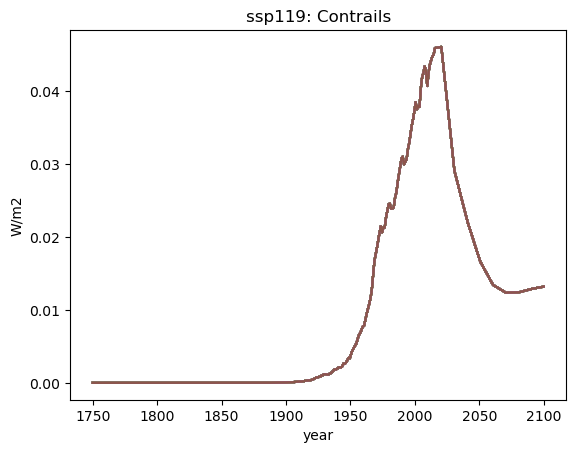

In [32]:
pl.plot(f.timebounds, f.forcing.loc[dict(scenario='ssp119', specie='Contrails')], label=f.configs);
pl.title('ssp119: Contrails')
pl.xlabel('year')
pl.ylabel('W/m2')

Text(0, 0.5, 'W/m2')

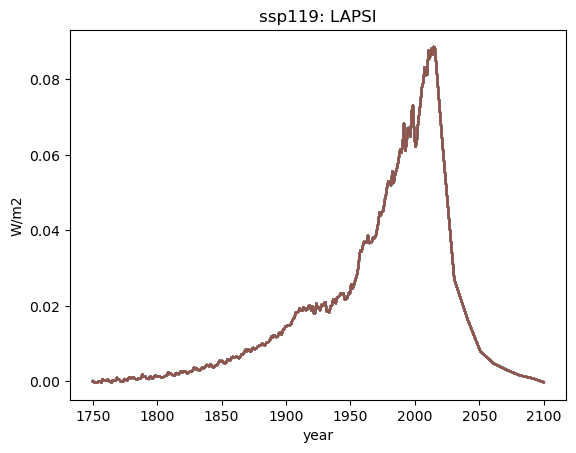

In [33]:
pl.plot(f.timebounds, f.forcing.loc[dict(scenario='ssp119', specie='Light absorbing particles on snow and ice')], label=f.configs);
pl.title('ssp119: LAPSI')
pl.xlabel('year')
pl.ylabel('W/m2')

Text(0, 0.5, 'W/m2')

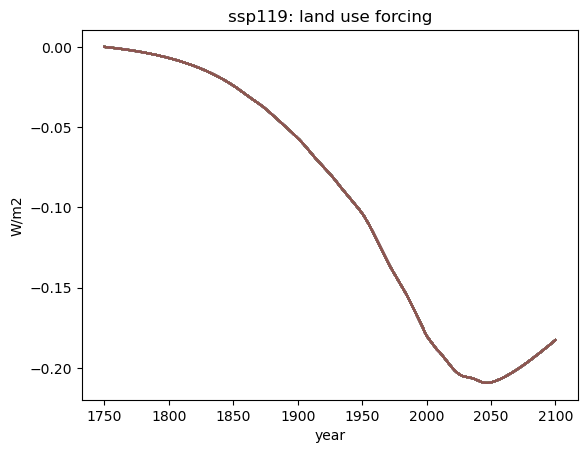

In [34]:
pl.plot(f.timebounds, f.forcing.loc[dict(scenario='ssp119', specie='Land use')], label=f.configs);
pl.title('ssp119: land use forcing')
pl.xlabel('year')
pl.ylabel('W/m2')

Text(0, 0.5, 'W/m2')

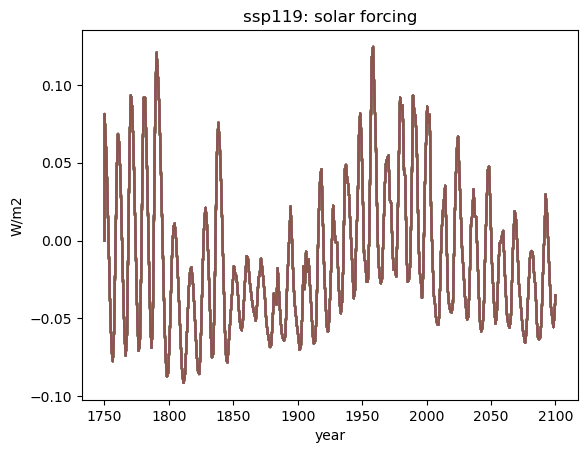

In [35]:
pl.plot(f.timebounds, f.forcing.loc[dict(scenario='ssp119', specie='Solar')], label=f.configs);
pl.title('ssp119: solar forcing')
pl.xlabel('year')
pl.ylabel('W/m2')

Text(0, 0.5, 'W/m2')

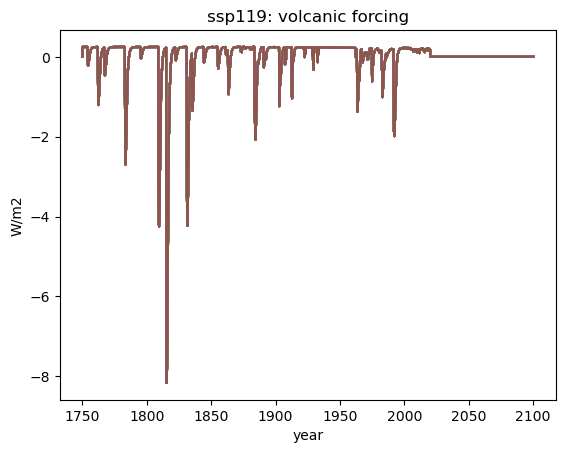

In [36]:
pl.plot(f.timebounds, f.forcing.loc[dict(scenario='ssp119', specie='Volcanic')], label=f.configs);
pl.title('ssp119: volcanic forcing')
pl.xlabel('year')
pl.ylabel('W/m2')

Text(0, 0.5, 'W/m2')

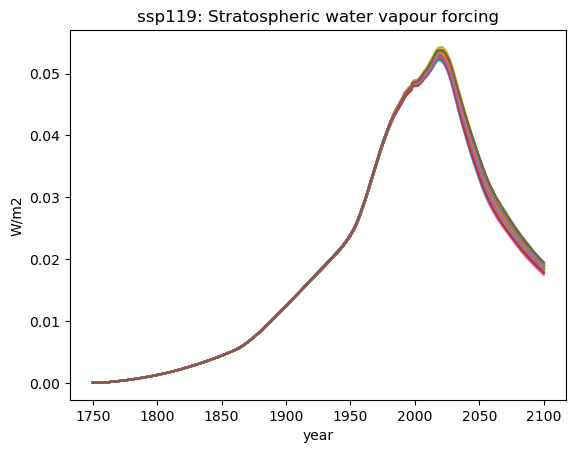

In [37]:
pl.plot(f.timebounds, f.forcing.loc[dict(scenario='ssp119', specie='Stratospheric water vapour')], label=f.configs);
pl.title('ssp119: Stratospheric water vapour forcing')
pl.xlabel('year')
pl.ylabel('W/m2')

Text(0, 0.5, 'Temperature anomaly (K)')

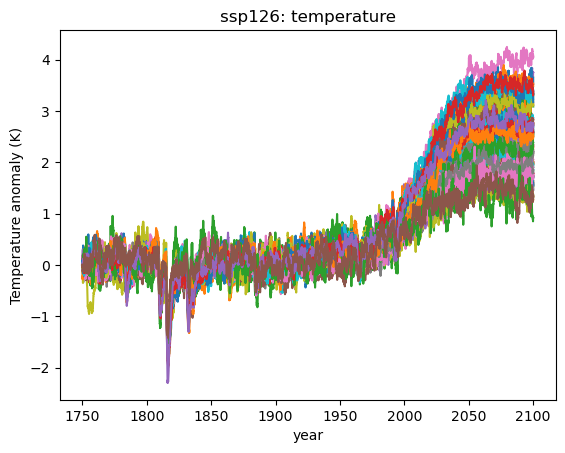

In [38]:
pl.plot(f.timebounds, f.temperature.loc[dict(scenario='ssp126', layer=0)], label=f.configs);
pl.title('ssp126: temperature')
pl.xlabel('year')
pl.ylabel('Temperature anomaly (K)')
#pl.legend()

Text(0, 0.5, 'Temperature anomaly (K)')

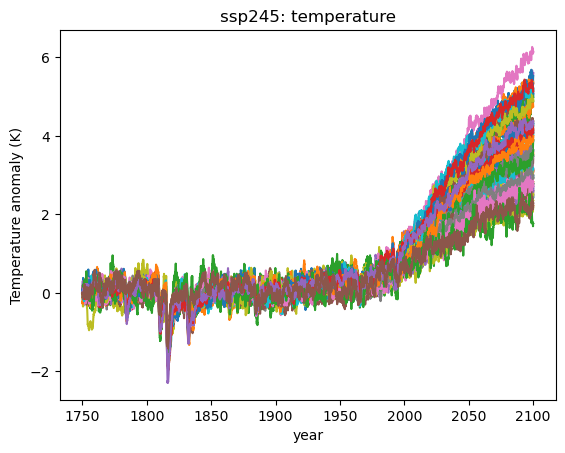

In [39]:
pl.plot(f.timebounds, f.temperature.loc[dict(scenario='ssp245', layer=0)], label=f.configs);
pl.title('ssp245: temperature')
pl.xlabel('year')
pl.ylabel('Temperature anomaly (K)')
#pl.legend()

Text(0, 0.5, 'Temperature anomaly (K)')

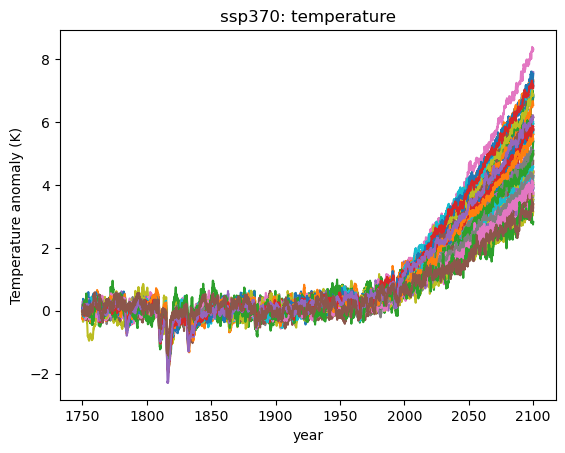

In [40]:
pl.plot(f.timebounds, f.temperature.loc[dict(scenario='ssp370', layer=0)], label=f.configs);
pl.title('ssp370: temperature')
pl.xlabel('year')
pl.ylabel('Temperature anomaly (K)')
#pl.legend()

Text(0, 0.5, 'Temperature anomaly (K)')

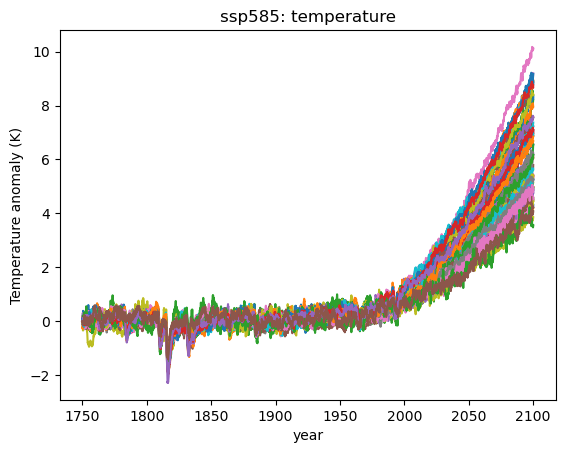

In [41]:
pl.plot(f.timebounds, f.temperature.loc[dict(scenario='ssp585', layer=0)], label=f.configs);
pl.title('ssp585: temperature')
pl.xlabel('year')
pl.ylabel('Temperature anomaly (K)')
#pl.legend()

Text(0, 0.5, 'W/m2')

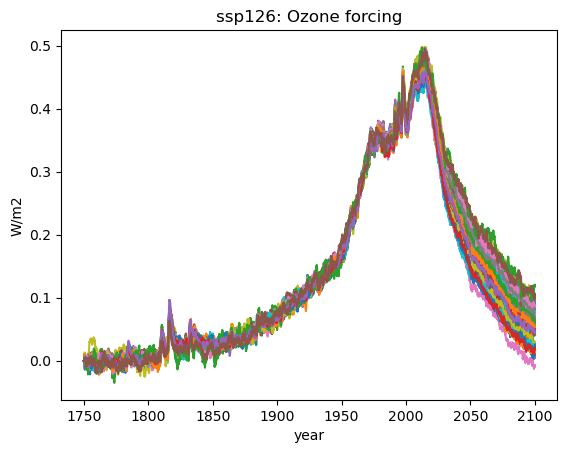

In [42]:
pl.plot(f.timebounds, f.forcing.loc[dict(scenario='ssp126', specie='Ozone')], label=f.configs);
pl.title('ssp126: Ozone forcing')
pl.xlabel('year')
pl.ylabel('W/m2')

Text(0, 0.5, 'W/m2')

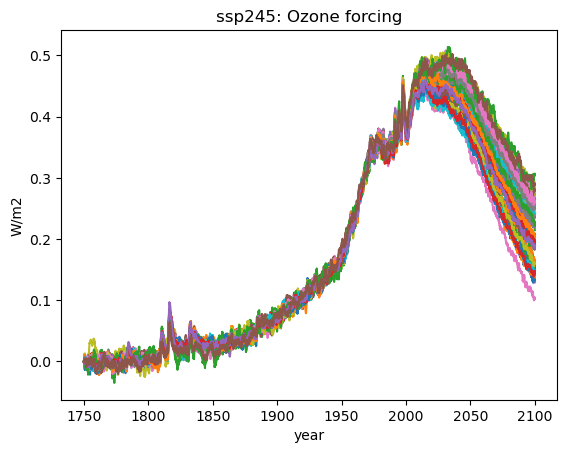

In [43]:
pl.plot(f.timebounds, f.forcing.loc[dict(scenario='ssp245', specie='Ozone')], label=f.configs);
pl.title('ssp245: Ozone forcing')
pl.xlabel('year')
pl.ylabel('W/m2')

Text(0, 0.5, 'W/m2')

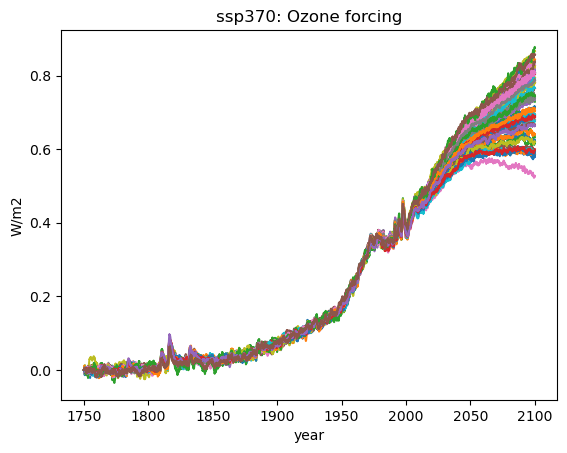

In [44]:
pl.plot(f.timebounds, f.forcing.loc[dict(scenario='ssp370', specie='Ozone')], label=f.configs);
pl.title('ssp370: Ozone forcing')
pl.xlabel('year')
pl.ylabel('W/m2')

Text(0, 0.5, 'W/m2')

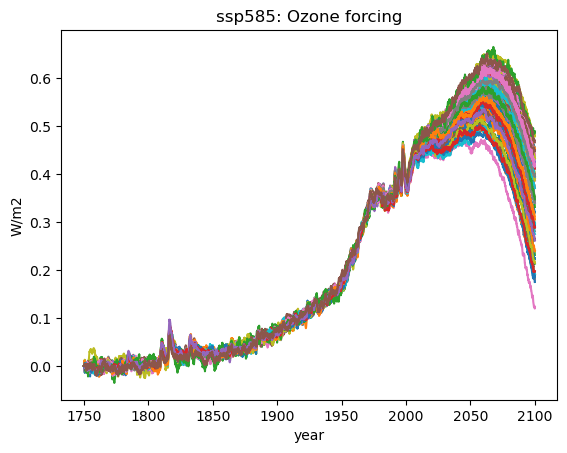

In [45]:
pl.plot(f.timebounds, f.forcing.loc[dict(scenario='ssp585', specie='Ozone')], label=f.configs);
pl.title('ssp585: Ozone forcing')
pl.xlabel('year')
pl.ylabel('W/m2')

Text(0, 0.5, 'GtCO2')

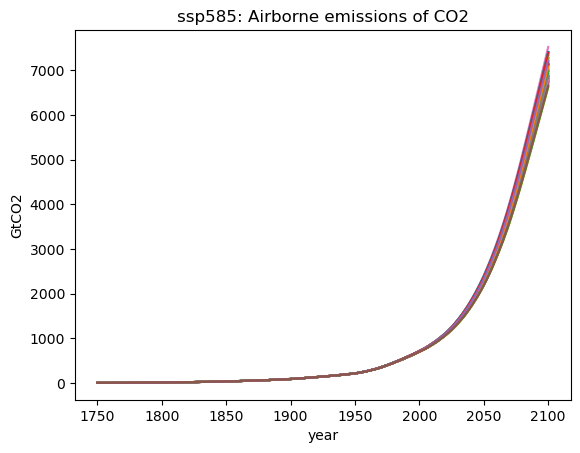

In [46]:
pl.plot(f.timebounds, f.airborne_emissions.loc[dict(scenario='ssp585', specie='CO2')], label=f.configs);
pl.title('ssp585: Airborne emissions of CO2')
pl.xlabel('year')
pl.ylabel('GtCO2')

Text(0, 0.5, '[1]')

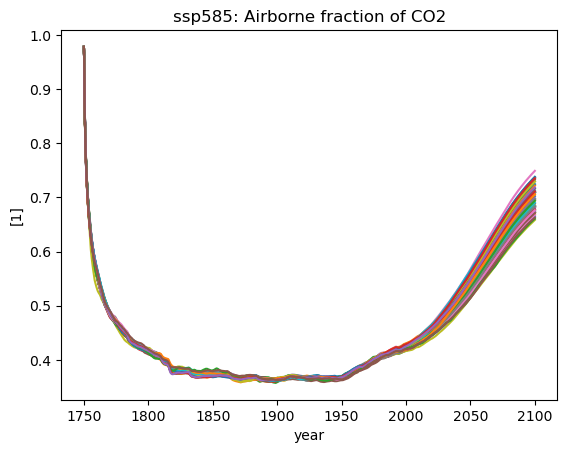

In [47]:
pl.plot(f.timebounds, f.airborne_fraction.loc[dict(scenario='ssp585', specie='CO2')], label=f.configs);
pl.title('ssp585: Airborne fraction of CO2')
pl.xlabel('year')
pl.ylabel('[1]')

Text(0, 0.5, 'GtCO2')

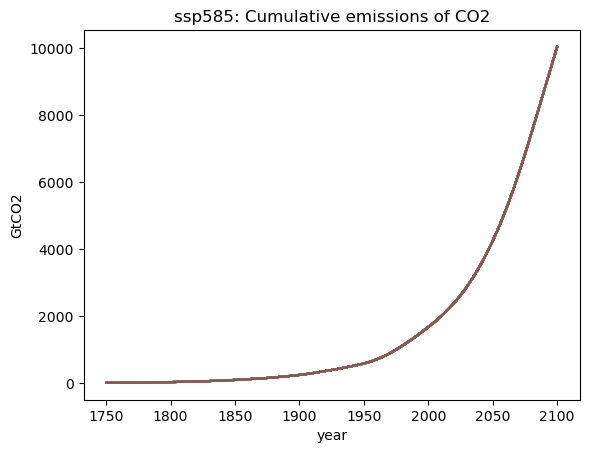

In [48]:
pl.plot(f.timebounds, f.cumulative_emissions.loc[dict(scenario='ssp585', specie='CO2')], label=f.configs);
pl.title('ssp585: Cumulative emissions of CO2')
pl.xlabel('year')
pl.ylabel('GtCO2')

Text(0, 0.5, 'J')

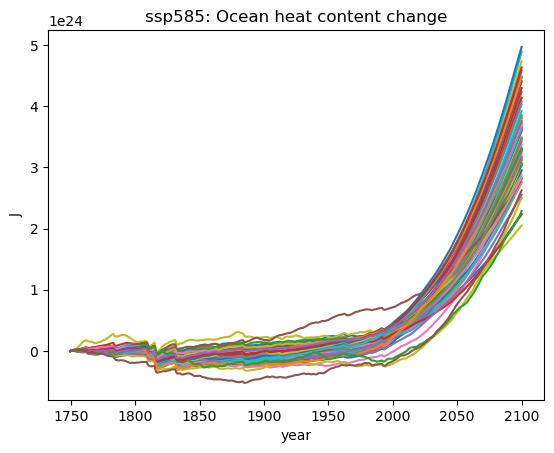

In [49]:
pl.plot(f.timebounds, f.ocean_heat_content_change.loc[dict(scenario='ssp585')], label=f.configs);
pl.title('ssp585: Ocean heat content change')
pl.xlabel('year')
pl.ylabel('J')

Text(0, 0.5, 'W m$^{-2}$')

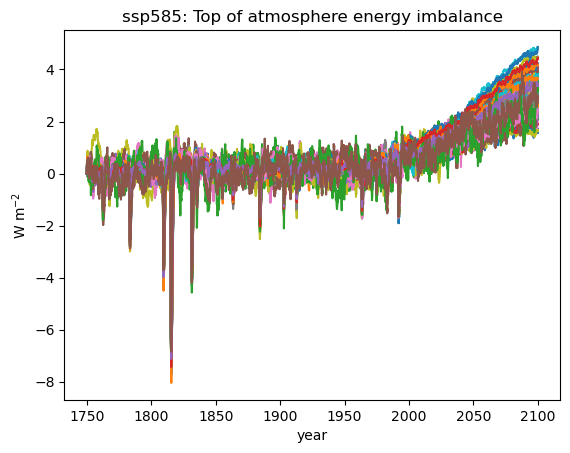

In [50]:
pl.plot(f.timebounds, f.toa_imbalance.loc[dict(scenario='ssp585')], label=f.configs);
pl.title('ssp585: Top of atmosphere energy imbalance')
pl.xlabel('year')
pl.ylabel('W m$^{-2}$')

Text(0, 0.5, 'W m$^{-2}$')

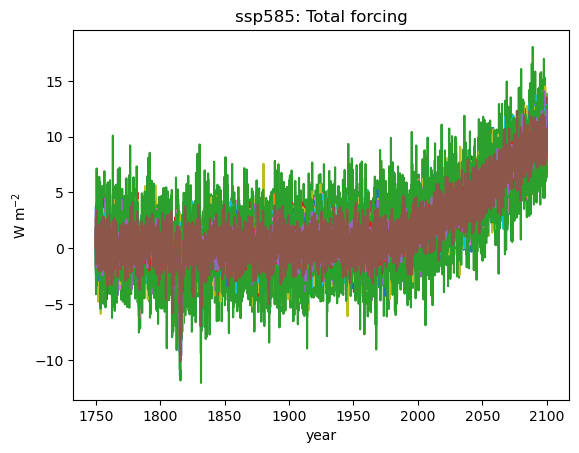

In [51]:
pl.plot(f.timebounds, f.stochastic_forcing.loc[dict(scenario='ssp585')], label=f.configs);
pl.title('ssp585: Total forcing')
pl.xlabel('year')
pl.ylabel('W m$^{-2}$')

Text(0, 0.5, 'W m$^{-2}$')

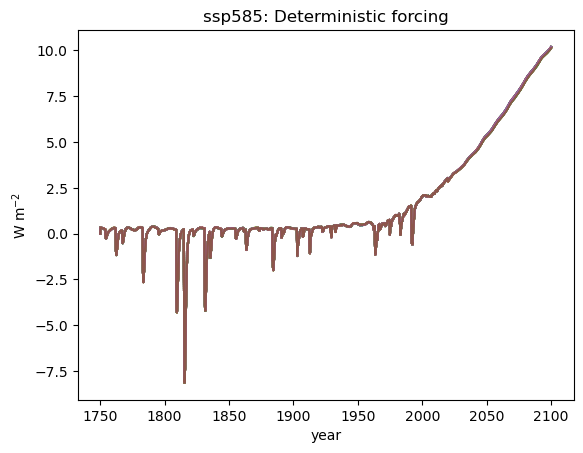

In [52]:
pl.plot(f.timebounds, f.forcing_sum.loc[dict(scenario='ssp585')], label=f.configs);
pl.title('ssp585: Deterministic forcing')
pl.xlabel('year')
pl.ylabel('W m$^{-2}$')

Text(0, 0.5, 'W m$^{-2}$')

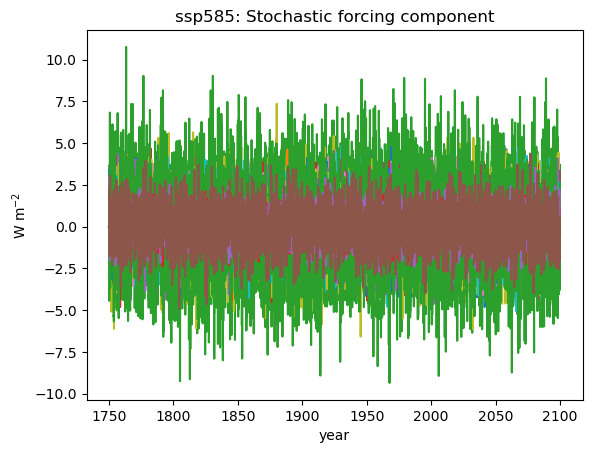

In [53]:
pl.plot(f.timebounds, f.stochastic_forcing.loc[dict(scenario='ssp585')]-f.forcing_sum.loc[dict(scenario='ssp585')], label=f.configs);
pl.title('ssp585: Stochastic forcing component')
pl.xlabel('year')
pl.ylabel('W m$^{-2}$')